In [27]:
using Distributions, QuadGK
using JuMP, OSQP
using LinearAlgebra
using Plots

[FORMULA PLACEHOLDER]

In [ ]:
function matern_kernel_0p5(t_i, t_j; sigma, rho)
    d = abs(t_i - t_j)
    return sigma^2 * exp(-d / rho)
end

function integrated_matern_kernel_0p5(t_i, t_j; sigma, rho)
    s = t_i - t_j
    d = abs(s)
    base = rho * (sigma^2) 
    if s < 0
        return base * (exp(-d / rho) - exp(-t_j / rho))
    else
        return base * (2 - exp(-d / rho) - exp(-t_j / rho))
    end
end

function matrices_matern_kernel_0p5(t, s; sigma, rho)
    K = [matern_kernel_0p5(t[i], s[j]; sigma, rho) for i in 1:length(t), j in 1:length(s)]
    K_tilde = [integrated_matern_kernel_0p5(t[i], s[j]; sigma, rho) for i in 1:length(t), j in 1:length(s)]
    return K, K_tilde
end

#The function is defined in "src/asset_pricing_baseline.jl"
function asset_pricing_baseline(t, c, g, r, x_0; T_max=2000.0)
    x(s) = (x_0 + c / g) * exp(g * s) - c / g
    discount_x(s) = exp(-r * s) * x(s)
    return [quadgk(discount_x, t_val, T_max)[1] for t_val in t] .* exp.(r .* t)
end

asset_pricing_baseline (generic function with 1 method)

Setting up the parameters

In [29]:
r = 0.1
c = 0.02
g = -0.2
x_0 = 0.01
sigma = 1.0
rho = 10.0

train_T = 40.0
train_points = 41
test_T = 50.0
test_points = 100

verbose = false
eps_abs = 1e-12
eps_rel = 1e-12
max_iter = 5000;

Training and testing grids

In [30]:
train_data = range(0, train_T, length=train_points)
test_data = range(0, test_T, length=test_points);

Kernel matrices and closed-form $x(t)$ solution

In [31]:
# Construct kernel matrices using nu=0.5
K, K_tilde = matrices_matern_kernel_0p5(train_data, train_data; sigma, rho)
K = Symmetric((K + K')/2) 
N = length(train_data)

x = (x_0 + c / g) .* exp.(g .* train_data) .- c / g;

Setting up the QP

In [32]:
model = Model(OSQP.Optimizer)

if !verbose
    set_silent(model)
end

set_attribute(model, "eps_abs", eps_abs)
set_attribute(model, "eps_rel", eps_rel)
set_attribute(model, "max_iter", max_iter)

@variable(model, alpha_mu[1:N])
@variable(model, mu_0 >= 0)

# Objective: minimize alpha' * K * alpha (using dot for symmetric K)
@objective(model, Min, dot(alpha_mu, K * alpha_mu))

# Constraints: dp/dt = r*p - x(t)
# where p(t) = mu_0 + K_tilde * alpha and dp/dt = K * alpha
@constraint(model, K * alpha_mu .== r * (mu_0 .+ K_tilde * alpha_mu) .- x)

optimize!(model)

Extracting solutions and building the interpolator

In [33]:
alpha = value.(alpha_mu)
p_0 = value(mu_0)
solve_time_sec = solve_time(model)

# Kernel solution interpolator
function kernel_solution(t_test)
    _, K_tilde_test = matrices_matern_kernel_0p5(t_test, train_data; sigma, rho)
    return p_0 .+ K_tilde_test * alpha
end


kernel_solution (generic function with 1 method)

Evaluating on the test grid

In [34]:
p_baseline = asset_pricing_baseline(test_data, c, g, r, x_0)
p_test = kernel_solution(test_data)
p_rel_error = abs.(p_baseline .- p_test) ./ p_baseline

println("solve_time(s) = $solve_time_sec, E(|rel_error(p)|) = $(mean(p_rel_error))")

solve_time(s) = 0.003558999, E(|rel_error(p)|) = 0.0001545779179179143


Plotting the result

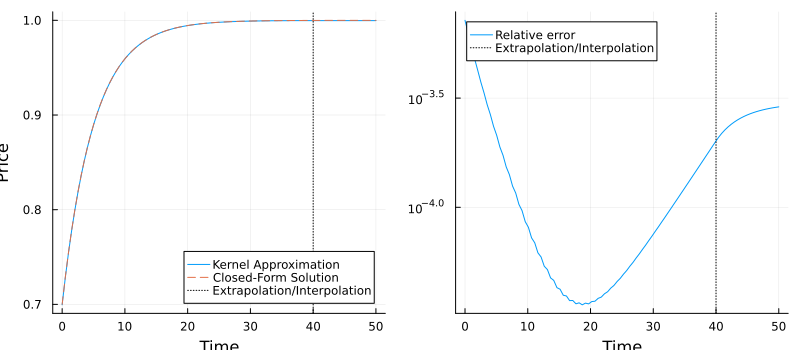

In [39]:
p1 = plot(
    test_data,
    p_test,
    label = "Kernel Approximation",
    xlabel = "Time",
    ylabel = "Price",
    legend = :bottomright,
)

plot!(
    test_data,
    p_baseline,
    linestyle = :dash,
    label = "Closed-Form Solution",
)

vline!(
    p1,
    [40],
    linestyle = :dot,
    color = :black,
    label = "Extrapolation/Interpolation",
)

p2 = plot(
    test_data,
    p_rel_error,
    label = "Relative error",
    xlabel = "Time",
    yscale = :log10,
    legend = :topleft,
)

vline!(
    p2,
    [40],
    linestyle = :dot,
    color = :black,
    label = "Extrapolation/Interpolation",
)

plot(p1, p2, layout = (1, 2), size = (800, 350))
